# Import and Function

# Predicting Inferior Temporal Cortex Responses During Visual Object Recognition 
### EPFL — NX-414 *Brain-Like Computation & Intelligence* | Mini-Project

**Authors:** Romain Frossard, Meriam Bouguecha, Mathieu Verest  
**Dataset:** Majaj et al. (2015) — 3,200 images × 168 multi-unit IT recordings  

---

**Goal:**  
Benchmark feature-to-response pipelines using Ridge regression to determine which model family best predicts neural firing rates in the IT cortex. We evaluate:

- Linear Baseline models: pixel-level regression, PCA + Ridge  
- Data-driven CNN: shallow convolutional network trained from scratch  
- Task-driven CNNs: ImageNet-pretrained feature extractors (ResNet-50)

---

## Imports and Functions:

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- Torch & torchvision ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# --- Model training utilities ---
import torch.optim as optim

# --- External models ---
import open_clip

# --- Data loading ---
import h5py
import gdown
from utils import load_it_data, visualize_img  

# --- Scikit-learn tools ---
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, r2_score

# --- Statistical metric ---
from scipy.stats import pearsonr


In [ ]:
# --- Utility Functions ---

def inverse_normalisation(images):
    """
    Undo ImageNet normalization for visualization.
    Input: NCHW tensor (numpy array) scaled and normalized as per ImageNet.
    Output: float32 array in [0, 1] with original color distribution.
    """
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    inv = images * std + mean
    return inv.astype(np.float32)


def compute_pearson_per_neuron(Y_val, Y_pred):
    """
    Compute Pearson correlation for each output neuron individually.
    Returns an array of correlations with shape (num_neurons,).
    """
    return np.array([
        pearsonr(Y_val[:, i], Y_pred[:, i])[0]
        for i in range(Y_val.shape[1])
    ])


def summarize(arr):
    """
    Compute 25th percentile, median, and 75th percentile of an array.
    """
    return {
        "P25": np.percentile(arr, 25),
        "median": np.median(arr),
        "P75": np.percentile(arr, 75),
    }


def eval_model(model, X_train, y_train, X_val, y_val):
    """
    Fit the model on (X_train, y_train), evaluate on X_val.
    Returns predictions and performance summaries (Explained Variance, Pearson r).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    ev = explained_variance_score(y_val, y_pred, multioutput="raw_values")
    r  = compute_pearson_per_neuron(y_val, y_pred)

    return y_pred, summarize(ev), summarize(r)


def plot_performance_metrics(Y_pred, model_name, Y_val, verbose=True):
    """
    Plot histograms of explained variance and Pearson correlation per neuron
    for predictions `Y_pred` against ground truth `Y_val`.
    """
    ev = explained_variance_score(Y_val, Y_pred, multioutput="raw_values")
    r  = compute_pearson_per_neuron(Y_val, Y_pred)

    if verbose:
        print(f"Explained Variance ({model_name}): {np.median(ev):.4f}")
        print(f"Median Pearson r ({model_name}): {np.median(r):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(ev, bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Count")

    sns.histplot(r, bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f"Pearson r ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


def boxplot_performance_metrics(list_pred, list_model_name, Y_val):
    """
    Create side-by-side boxplots of explained variance and Pearson r
    for multiple models.
    """
    ev_dict = {}
    r_dict  = {}

    for preds, name in zip(list_pred, list_model_name):
        ev = explained_variance_score(Y_val, preds, multioutput="raw_values")
        r  = compute_pearson_per_neuron(Y_val, preds)
        ev_dict[name] = ev
        r_dict[name]  = r

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].boxplot(ev_dict.values(), labels=ev_dict.keys())
    axes[0].set_ylabel("Explained Variance")
    axes[0].set_title("Explained Variance by Model")

    axes[1].boxplot(r_dict.values(), labels=r_dict.keys())
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_title("Pearson Correlation by Model")

    plt.tight_layout()
    plt.show()


# Linear Baseline Models

As a first benchmark, we evaluate simple linear models trained directly on raw pixel.

- We flatten each grayscale image (224 × 224) into a 50,176-dimensional feature vector.
- Two models are tested:
  - **OLS (Ordinary Least Squares)**
  - **Ridge Regression** (with α = 1000)

This setup provides a naive reference point to assess how well raw image statistics can predict multi-unit firing rates in IT cortex.

In [42]:
#Loading Data
path_to_data = './' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [43]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [44]:
# Undo ImageNet normalization
inv_stimulus_train = inverse_normalisation(stimulus_train)
inv_stimulus_val = inverse_normalisation(stimulus_val)

# check RGB channles are identical
diff01 = np.max(np.abs(inv_stimulus_train[:,0,:,:] - inv_stimulus_train[:,1,:,:]))
diff02 = np.max(np.abs(inv_stimulus_train[:,0,:,:] - inv_stimulus_train[:,2,:,:]))
print("Max abs diff ch0–ch1:", diff01)
print("Max abs diff ch0–ch2:", diff02)
 
# Keep only one channel
single_train = inv_stimulus_train[:, 1, :, :]  # shape (N, H, W)
single_val   = inv_stimulus_val  [:, 1, :, :]  # shape (M, H, W)`

# Flatten images for regression
X_flat_train = single_train.reshape(inv_stimulus_train.shape[0], -1)  
X_flat_val = single_val.reshape(inv_stimulus_val.shape[0], -1)  
Y_train = spikes_train  
Y_val = spikes_val  

X_flat_train.shape #should be (N, 224x224) --> ok !

Max abs diff ch0–ch1: 1.1920929e-07
Max abs diff ch0–ch2: 1.1920929e-07


(2592, 50176)

EV :  {'P25': -0.5485553741455078, 'median': -0.43694776, 'P75': -0.3012164831161499} {'P25': -0.3199612498283386, 'median': -0.21061301, 'P75': -0.09382021427154541}
r  :  {'P25': 0.12033968046307564, 'median': 0.17770536, 'P75': 0.2572225108742714} {'P25': 0.12652516551315784, 'median': 0.20730019, 'P75': 0.28355757147073746}


/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/3975910495.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(ev_dict.values(), labels=ev_dict.keys())
/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/3975910495.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(r_dict.values(), labels=r_dict.keys())


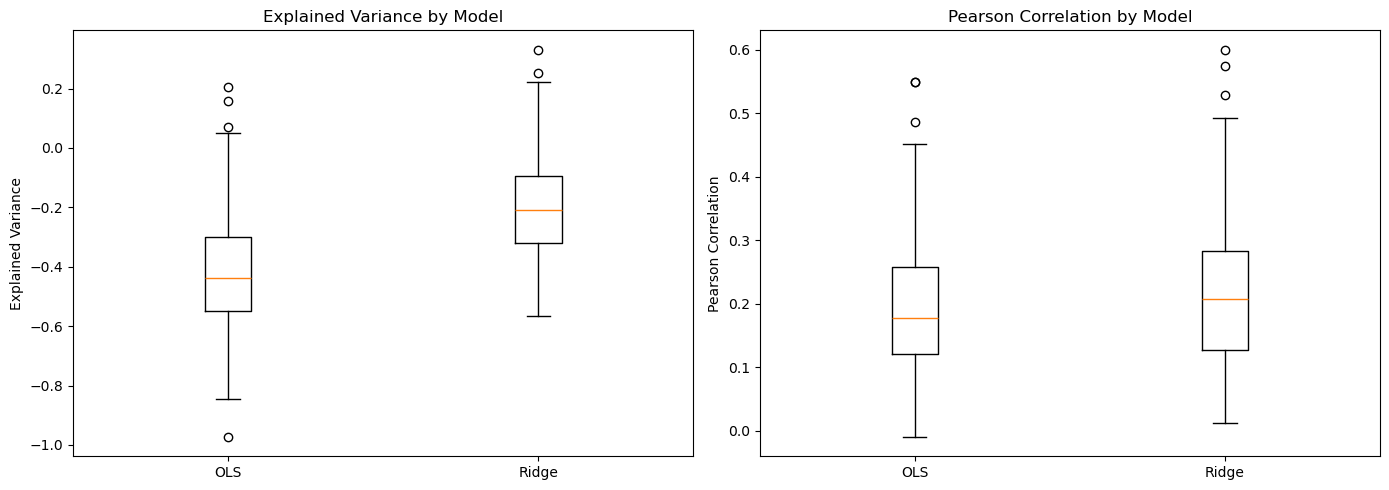

In [46]:
# Define baseline models
baselines = {
    "OLS":   make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1000))
}

results, predictions = {}, {}

for name, pipe in baselines.items():
    y_hat, ev_str, r_str = eval_model(pipe, X_flat_train, Y_train, X_flat_val, Y_val)
    predictions[name]   = y_hat
    results[name]       = {"EV": ev_str, "r": r_str}

# Display and plot performance 
    
y_pred_OLS  = predictions["OLS"]
y_pred_Ridge = predictions["Ridge"]
print("EV : ",results["OLS"]["EV"], results["Ridge"]["EV"])
print("r  : ",results["OLS"]["r"], results["Ridge"]["r"])

boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge], ["OLS", "Ridge"], Y_val)

Despite slight improvements from regularization, both models fail to capture the structure of IT responses. These results suggest that pixel-level representations are insufficient and justify the move to more informative features.

## Improving the Linear Baseline: PCA + Ridge

The poor performance of raw pixel regression suggests the need for feature compression and regularization. We now apply PCA to reduce dimensionality before fitting a Ridge regression model.

We use the best hyperparameters (selected by grid search on the validation set):  
- **Ridge regularization**: α = 100000  
- **Number of PCA components**: 1200

This setup allows the model to focus on the most informative visual features while avoiding overfitting.

Here is the grid search code:

In [ ]:
# Assign training and validation data
X = X_flat_train
Y= Y_train
X_val = X_flat_val
Y_val = Y_val

# Define range of PCA components and Ridge regularization strengths
pca_dims = [400, 600, 800, 1000, 1200, 1400,1800]
alphas = np.logspace(0, 5, 6)
display(alphas, pca_dims)

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track best explained variance score (EVS) and corresponding parameters
best_evs   = -np.inf
best_params = {}
results = []
print("Starting CV")

ev_scores = []

# Loop through each PCA dimension
for n_comp in tqdm(pca_dims, desc="n_components"):
    # Loop through each regularization strength
    for alpha in tqdm(alphas, desc=f"α @ n={n_comp}", leave=False):
        ev_folds = []
        r_folds  = []
        # Cross-validation fold loop
        for train_idx, val_idx in cv.split(X, objects_train):
            X_tr, X_cv = X[train_idx], X[val_idx]
            y_tr, y_cv = Y[train_idx], Y[val_idx]

            # Normalize features
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_cv = scaler.transform(X_cv)
            
            # Apply PCA
            pca = PCA(n_components=n_comp, random_state=42)
            X_tr = pca.fit_transform(X_tr)
            X_cv = pca.transform(X_cv)
            
            # Train Ridge regression model
            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_cv)

            # Calculate evaluation metrics
            ev  = explained_variance_score(y_cv, y_pred,
                                           multioutput='raw_values')
            r   = compute_pearson_per_neuron(y_cv, y_pred)

            # Store median scores per fold
            ev_folds.append(np.median(ev))
            r_folds.append(np.median(r))

        # Average metrics across folds
        mean_evs = np.mean(ev_folds)
        mean_r  = np.mean(r_folds)
        
        
        # Store this parameter combination's results
        results.append({
            'n_components':     n_comp,
            'alpha':            alpha,
            'cv_mean_evs':      mean_evs,
            'cv_mean_corr':     mean_r,
        })

        # Update best parameters if this is the best so far
        if mean_evs > best_evs:
            best_evs    = mean_evs
            best_params = {'n_components': n_comp, 'alpha': alpha}

# Output best hyperparameters and score
print("\nBest CV params (by EVS):")
print(f"  n_components = {best_params['n_components']}")
print(f"  alpha        = {best_params['alpha']:.3f}")
print(f"  CV EVS       = {best_evs:.4f}")




In [ ]:
#compare all tested PCA/alpha combinations, with the top-performing configuration at the top
results = pd.DataFrame(results)
results = results.sort_values(by='cv_mean_evs', ascending=False)
results 

Here's the model implementation with grid search results, compared with models without grid search:

Test optimal model using : Best alpha: 100000.0, n_components: 1200
----------------------------------------------------------------




/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/3975910495.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(ev_dict.values(), labels=ev_dict.keys())
/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/3975910495.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(r_dict.values(), labels=r_dict.keys())


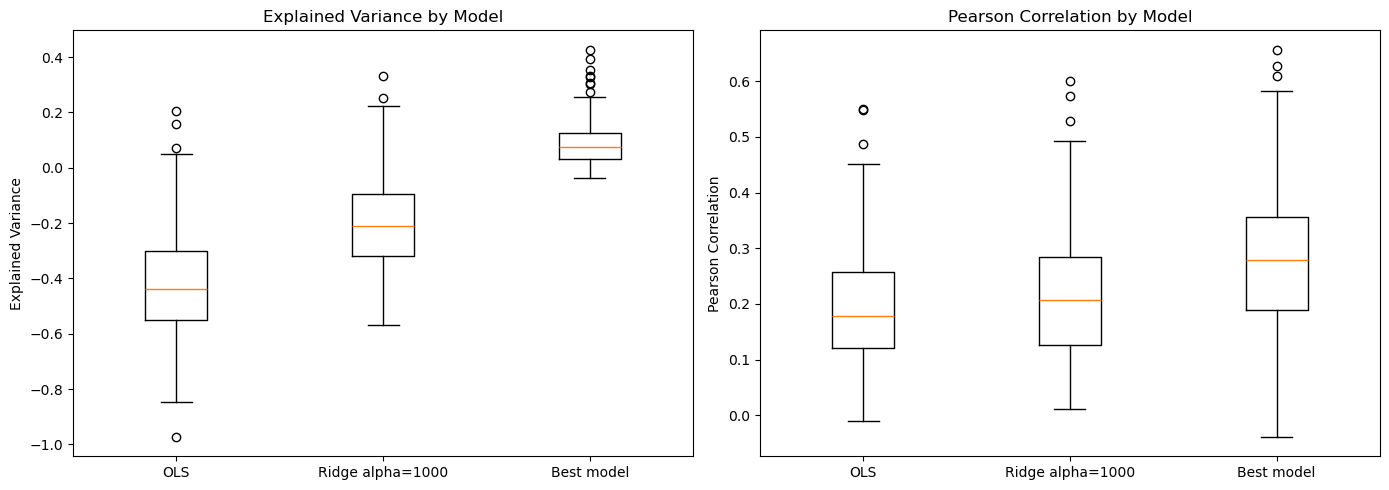

,P25,median,P75
0,0.033066,0.076566,0.12485


,P25,median,P75
0,0.189884,0.279623,0.356595


In [47]:
# Best hyperparameters (found via grid search on validation set)
best_alpha = 100000.0
best_n_comp = 1200
print(f"Test optimal model using:\nBest alpha: {best_alpha}, n_components: {best_n_comp}")
print("------------------------------------------------------------\n")

# PCA + Ridge model pipeline
best_model = make_pipeline(StandardScaler(), PCA(n_components=best_n_comp), Ridge(alpha=best_alpha))

# Fit and evaluate on validation set
best_model.fit(X_flat_train, Y_train)
y_pred_best = best_model.predict(X_flat_val)

# Compare against previous baselines
boxplot_performance_metrics([y_pred_OLS, y_pred_Ridge, y_pred_best], ["OLS", "Ridge alpha=1000", "Best model"], Y_val)

# Summary statistics
ev = explained_variance_score(Y_val, y_pred_best, multioutput="raw_values")
r  = compute_pearson_per_neuron(Y_val, y_pred_best)

display(pd.DataFrame([summarize(ev)]), pd.DataFrame([summarize(r)]))

# Data-Driven Model: Shallow CNN Trained from Scratch

To test whether a simple neural network can learn visual features predictive of IT responses, we train a custom convolutional network (VanillaCNN) directly on image–response pairs.

- The model consists of 3 convolutional blocks (Conv → BatchNorm → ReLU → MaxPool)
- The output is passed through two fully connected layers to predict the 168 firing rates
- We use grayscale input (1 channel), normalized per image statistics
- The network is trained from scratch with MSE loss and AdamW optimizer

This model represents a lightweight data-driven alternative to pretrained CNNs and provides a comparison point for how well features can be learned from limited data.

In [ ]:
#Loading Data
path_to_data = './'
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [52]:
class NA_Dataset(Dataset):
    def __init__(self, images_array, spikes_array, transform = None):
        self.images = images_array
        self.target = spikes_array
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        if self.transform:
            image = self.transform(image)
        else : 
            image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)        
        return image, target
 
class VanillaCNN(nn.Module):
    def __init__(self, num_channels, num_outputs, image_size=224):
        super(VanillaCNN, self).__init__()
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16 , kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Third convolution block
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
                
        self.pool = nn.MaxPool2d(2, 2)
        reduced_size = image_size // 8 
        self.fc1 = nn.Linear(32 * reduced_size * reduced_size, 512)
        self.fc2 = nn.Linear(512, num_outputs)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Epoch 1/50 — Train Loss: 0.1333, Val Loss: 0.1391
Epoch 2/50 — Train Loss: 0.1203, Val Loss: 0.1253
Epoch 3/50 — Train Loss: 0.1096, Val Loss: 0.1154
Epoch 4/50 — Train Loss: 0.1041, Val Loss: 0.1113
Epoch 5/50 — Train Loss: 0.1024, Val Loss: 0.1106
Epoch 6/50 — Train Loss: 0.1037, Val Loss: 0.1117
Epoch 7/50 — Train Loss: 0.0974, Val Loss: 0.1076
Epoch 8/50 — Train Loss: 0.0959, Val Loss: 0.1066
Epoch 9/50 — Train Loss: 0.0929, Val Loss: 0.1053
Epoch 10/50 — Train Loss: 0.0911, Val Loss: 0.1050
Epoch 11/50 — Train Loss: 0.0917, Val Loss: 0.1045
Epoch 12/50 — Train Loss: 0.0903, Val Loss: 0.1029
Epoch 13/50 — Train Loss: 0.0888, Val Loss: 0.1022
Epoch 14/50 — Train Loss: 0.0882, Val Loss: 0.1028
Epoch 15/50 — Train Loss: 0.0861, Val Loss: 0.1012
Epoch 16/50 — Train Loss: 0.0887, Val Loss: 0.1018
Epoch 17/50 — Train Loss: 0.0878, Val Loss: 0.1012
Epoch 18/50 — Train Loss: 0.0882, Val Loss: 0.1022
Epoch 19/50 — Train Loss: 0.0849, Val Loss: 0.0995
Epoch 20/50 — Train Loss: 0.0856, Val Lo

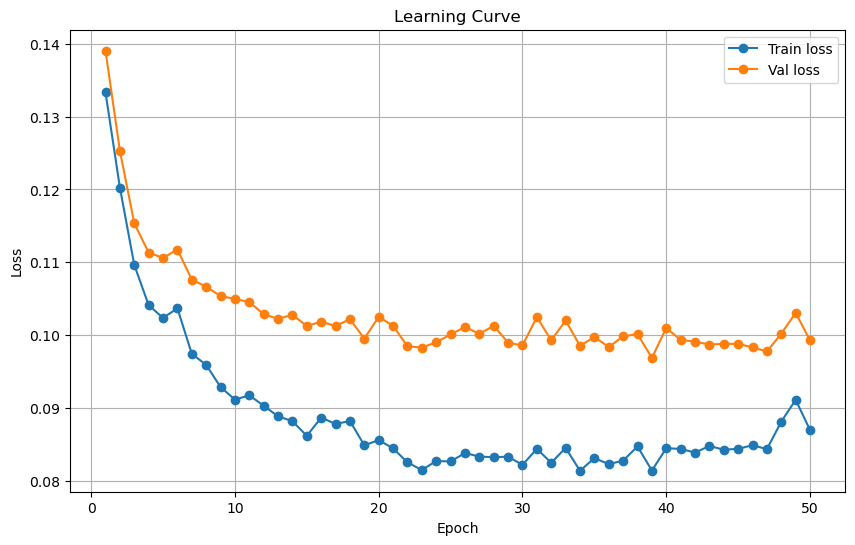

Explained Variance: {'P25': 0.1750856190919876, 'median': 0.27948943, 'P75': 0.3514255881309509}
Pearson Correlation: {'P25': 0.43208110332489014, 'median': 0.53792983, 'P75': 0.6116848587989807}


In [ ]:
 # Normalize grayscale channel
inv_stimulus_train = inverse_normalisation(stimulus_train)
inv_stimulus_val = inverse_normalisation(stimulus_val)
single_train = inv_stimulus_train[:, 1, :, :] 
single_val   = inv_stimulus_val  [:, 1, :, :]
channel_mean, channel_std = single_train.mean(), single_train.std()


trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= [channel_mean], std= [channel_std])
]) 
# Dataset and loader
df_train = NA_Dataset(single_train, spikes_train, trans)
df_val = NA_Dataset(single_val, spikes_val, trans)
train_loader = DataLoader(df_train, batch_size=16, shuffle=True)
val_loader = DataLoader(df_val, batch_size=16, shuffle=False)

# Training
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
num_channels = 1
image_size = stimulus_train.shape[2]
num_outputs = spikes_train.shape[1]


model = VanillaCNN(num_channels, num_outputs, image_size=image_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs = 50
# scheduler = CosineAnnealingLR(
#     optimizer,
#     T_max= num_epochs - num_epochs//10,
#     eta_min=0.0,
# )
train_loss, val_loss = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    model.eval()
    running_train, total_train = 0.0, 0
    running_val,   total_val   = 0.0, 0
    predictions,   true_values = [], []

    with torch.no_grad():
        for images, targets in train_loader:
            bs = images.size(0)
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            l = criterion(outputs, targets)
            running_train += l.item() * bs
            total_train   += bs
        for images, targets in val_loader:
            bs = images.size(0)
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            l = criterion(outputs, targets)
            running_val   += l.item() * bs
            total_val     += bs
            predictions.append(outputs.cpu())
            true_values.append(targets.cpu())

    train_epoch_loss = running_train / total_train
    val_epoch_loss   = running_val   / total_val

    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {train_epoch_loss:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}")

# Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_loss, marker='o', label='Train loss')
plt.plot(range(1, num_epochs+1), val_loss,   marker='o', label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model
Y_pred = torch.cat(predictions, dim=0).numpy()
Y_val  = torch.cat(true_values, dim=0).numpy()

ev =summarize(explained_variance_score(Y_val, Y_pred, multioutput='raw_values'))
r  =summarize(compute_pearson_per_neuron(Y_val, Y_pred))

print(f"Explained Variance: {ev}")
print(f"Pearson Correlation: {r}")



This model outperforms all earlier baselines, including PCA + Ridge. Despite being shallow and trained on limited data, it captures a meaningful share of IT response variance, showing that simple end-to-end networks can learn brain-relevant features.

# Task-Driven Features: Transfer Learning from ResNet-50

We evaluate task-driven representations using a frozen ResNet-50 pretrained on ImageNet. Feature activations are extracted at multiple intermediate layers, and a PCA + Ridge decoder is trained to predict IT firing rates from each.

- **Frozen ResNet-50**: pre-trained weights, no fine-tuning
- **Feature layers evaluated**: conv1 → avgpool
- **Decoder**: PCA (1200 components) + Ridge (α = 100000)

This approach tests how well hierarchical CNN representations trained on object recognition transfer to predicting brain activity.

In [59]:
#Loading Data
path_to_data = './' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [60]:
n_comp = 1200
alpha = 100000.0

# Load pretrained ResNet50 and select intermediate layers
resnet = resnet50(pretrained=True).to(device).eval()
return_nodes = {
    'conv1':'conv1','layer1':'layer1','layer2':'layer2',
    'layer3':'layer3','layer4':'layer4','avgpool':'avgpool'
}
feature_extractor = create_feature_extractor(resnet, return_nodes).to(device)

# DataLoader
train_ds = TensorDataset(torch.tensor(stimulus_train, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)
val_ds   = TensorDataset(torch.tensor(stimulus_val,   dtype=torch.float32))
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

# Extract features from a given ResNet layer
def extract_activations(loader, layer, extractor):
    """
    Flatten and return activations from `layer` for all images in `loader`.
    Pass a feature extractor built from any ResNet-50 instance—pretrained or random—via
    `extractor`.
    """
    acts = []
    with torch.no_grad():
        for (imgs,) in loader:
            imgs = imgs.to(device)
            feats = extractor(imgs)
            flat = feats[layer].view(imgs.size(0), -1)
            acts.append(flat.cpu().numpy())
    return np.vstack(acts)


# Evaluate each ResNet layer
explained_variances = {}
pearson_scores = {}
predictions = {}

for layer in return_nodes.values():
    print(f"\nProcessing layer: {layer}")

    X_train = extract_activations(train_loader, layer , feature_extractor)
    X_val   = extract_activations(val_loader,   layer, feature_extractor)

    pca = PCA(n_components=n_comp, random_state=42)
    X_pca_train = pca.fit_transform(X_train)
    X_pca_val   = pca.transform(X_val)

    model = Ridge(alpha=alpha)
    model.fit(X_pca_train, spikes_train)        
    Y_pred = model.predict(X_pca_val)
    predictions[layer] = Y_pred

    ev = explained_variance_score(spikes_val, Y_pred, multioutput='raw_values')
    explained_variances[layer] = np.median(ev)

    pearsons = compute_pearson_per_neuron(spikes_val, Y_pred)
    pearson_scores[layer] = np.median(pearsons)

    print(f"Layer {layer} | median EV: {explained_variances[layer]:.4f} "
          f"| median Pearson: {pearson_scores[layer]:.4f} | α={alpha}, n_comp={n_comp}")

/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing layer: conv1
Layer conv1 | median EV: -0.0170 | median Pearson: 0.2373 | α=100000.0, n_comp=1200

Processing layer: layer1
Layer layer1 | median EV: 0.1652 | median Pearson: 0.4893 | α=100000.0, n_comp=1200

Processing layer: layer2
Layer layer2 | median EV: 0.1522 | median Pearson: 0.4961 | α=100000.0, n_comp=1200

Processing layer: layer3
Layer layer3 | median EV: 0.1080 | median Pearson: 0.5322 | α=100000.0, n_comp=1200

Processing layer: layer4
Layer layer4 | median EV: 0.3883 | median Pearson: 0.6366 | α=100000.0, n_comp=1200

Processing layer: avgpool
Layer avgpool | median EV: 0.0676 | median Pearson: 0.4254 | α=100000.0, n_comp=1200


/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/2372491676.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(ev_dict.values(), labels=ev_dict.keys())
/var/folders/t_/qjzw0tfs4c1b4y9_lbr0j6x00000gn/T/ipykernel_1660/2372491676.py:124: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(r_dict.values(), labels=r_dict.keys())


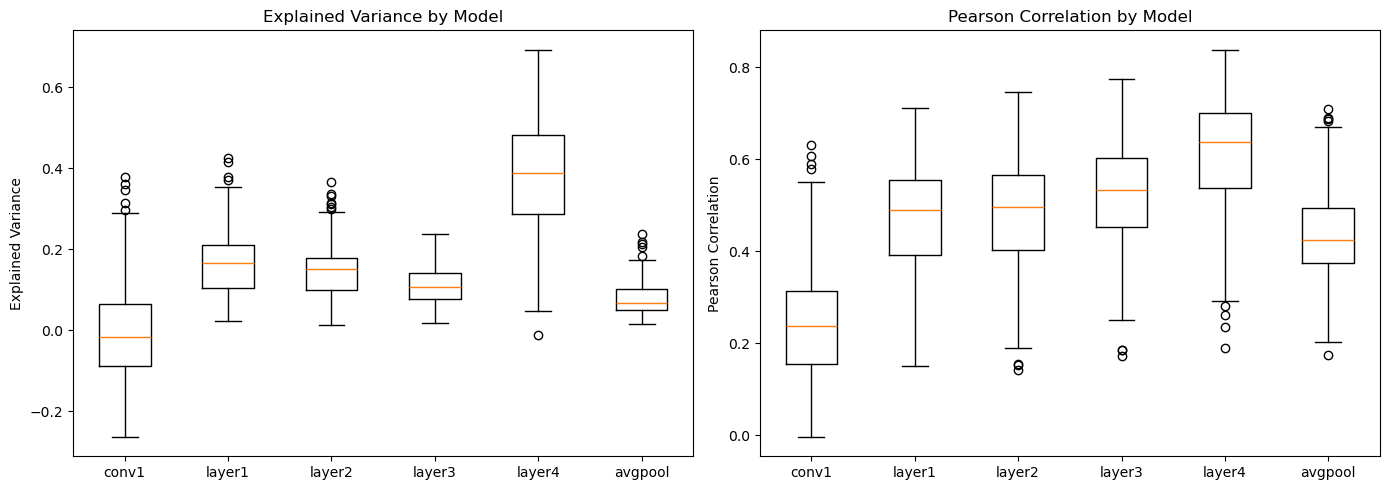

pearson r layer4 :{'P25': 0.5375222861766815, 'median': 0.63664097, 'P75': 0.7005599290132523}
median layer 4: {'P25': 0.28763896226882935, 'median': 0.38832018, 'P75': 0.4831858426332474}


In [62]:
model_names = ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]
pred = [predictions[l] for l in model_names]


boxplot_performance_metrics(pred, model_names, spikes_val)

print(f"pearson r layer4 :{summarize(compute_pearson_per_neuron(spikes_val, predictions['layer4']))}")
print(f"median layer 4: {summarize(explained_variance_score(spikes_val, predictions['layer4'], multioutput='raw_values'))}")


This shows that high-level task-driven representations, trained for object recognition, transfer remarkably well to modeling IT responses ,even outperforming the data-driven CNN trained from scratch.

## Control Model: Randomly Initialized ResNet-50 (Untrained)

To test whether the success of task-driven models depends on training, we repeat the layer4 analysis using a **ResNet-50 with random weights**.

- Only layer4 is used (same as best-performing pretrained model)
- No supervised training — the weights are randomly initialized
- Same PCA + Ridge decoding setup (n_components = 1200, α = 100000)

This control helps isolate the contribution of task-driven learning from architecture alone.

In [63]:
n_comp = 1200
alpha = 100000.0
device = "mps" if torch.backends.mps.is_available() else "cpu"

resnet_rand = resnet50(pretrained=False).to(device).eval()
feature_extractor_rand = create_feature_extractor(
    resnet_rand,
    return_nodes={'layer4': 'layer4'}
).to(device)

# Data loaders
train_ds = TensorDataset(torch.tensor(stimulus_train, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)
val_ds   = TensorDataset(torch.tensor(stimulus_val,   dtype=torch.float32))
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

def extract_layer3(loader):
    acts = []
    with torch.no_grad():
        for (imgs,) in loader:
            imgs = imgs.to(device)
            feats = feature_extractor_rand(imgs)['layer4']
            flat  = feats.view(imgs.size(0), -1)   # → (B, C*H*W)
            acts.append(flat.cpu().numpy())
    return np.vstack(acts)

X_train = extract_layer3(train_loader)
X_val   = extract_layer3(val_loader)


pca = PCA(n_components=n_comp,)
X_pca_train = pca.fit_transform(X_train)
X_pca_val   = pca.transform(X_val)



model = Ridge(alpha=alpha)
model.fit(X_pca_train, spikes_train)     
Y_pred = model.predict(X_pca_val)

ev_values = explained_variance_score(spikes_val, Y_pred, multioutput='raw_values')
ev = summarize(ev_values)
pearsons   = compute_pearson_per_neuron(spikes_val, Y_pred)
r = summarize(pearsons)

print(f"Median Pearson Correlation: {r}")
print(f"Median Explained Variance: {ev}")


/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Median Pearson Correlation: {'P25': 0.3097211569547653, 'median': 0.4214242, 'P75': 0.5062668472528458}
Median Explained Variance: {'P25': 0.07300150394439697, 'median': 0.16778979, 'P75': 0.25396834313869476}


Random ResNet-50 features reduce the median correlation from ≈ 0.64 to ≈ 0.42, confirming that architecture helps, but task-driven training accounts for most of the predictive power.

# Optimal Model Exploration
In this section, we take our experiments a step further to find the best possible model.
We use a pre-trained ResNet50 to extract deep visual features from image stimuli, selecting intermediate layers (layer 3 and layer 4) for their representational richness. PCA is applied to reduce the dimensionality of these activations while retaining 99% of the variance. Ridge regression is first used with cross-validation to find the optimal regularization strength (alpha) for predicting neural spike responses. Next, a more flexible two-layer feedforward neural network is trained using the same features reduced by PCA, with dropout and optional L2 regularization to avoid over-fitting. The best model is evaluated on validation data and its weights are saved.

In [2]:
#Loading Data
path_to_data = './' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

inv_stimulus_train = inverse_normalisation(stimulus_train)
inv_stimulus_val = inverse_normalisation(stimulus_val)
Y_train = spikes_train
Y_val = spikes_val

### Extract layer 3 and 4 Pretrained ResNet50
Extraction and flattening of intermediate visual feature representations of a pre-trained ResNet50 (layers 3 and 4) for each training and validation stimulus image using PyTorch's feature extraction utility.

In [3]:

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# Load a pretrained ResNet-50 model
resnet = resnet50(pretrained=True)
resnet.eval()  

# Specify the intermediate layers from which we want to extract features
return_nodes = {
    'layer3': 'layer3',
    'layer4': 'layer4',
}

# Create a feature extractor that outputs activations from the specified layers
feature_extractor = create_feature_extractor(resnet, return_nodes=return_nodes).to(device)

# Wrap the training and validation stimuli in TensorDatasets and DataLoaders for batch processing
train_ds = TensorDataset(torch.tensor(stimulus_train, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)
val_ds   = TensorDataset(torch.tensor(stimulus_val,   dtype=torch.float32))
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

# Dictionaries to store extracted activations for each layer
activations_dct_train = {}
activations_dct_val = {}

# Iterate over the selected layers to extract activations
for layer_name in  return_nodes.values() :
    print(f"\nProcessing layer: {layer_name}")
    # Extract activations from training data
    activations_train = []
    with torch.no_grad():
        for batch in train_loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_train.append(act.cpu().numpy())
    X_train = np.vstack(activations_train)

    # Extract activations from validation data
    activations_val = []
    
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_val.append(act.cpu().numpy())
    X_val = np.vstack(activations_val)

    # Store activations in dictionaries, keyed by layer name
    activations_dct_train[layer_name] = X_train
    activations_dct_val[layer_name] = X_val
# Check the shape of the extracted features for both layers in the training set
activations_dct_train['layer3'].shape, activations_dct_train['layer4'].shape

Using device: mps


/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing layer: layer3

Processing layer: layer4


((2592, 200704), (2592, 100352))

### PCA to keep k components explaining 99% of variance
PCA to the features extracted from each ResNet layer to reduce dimensionality while preserving 99% of the variance explained

In [4]:
# Threshold for the proportion of variance to retain after PCA
explained_variance_threshold = 0.99

pca_models_train = {}
pca_activations_train = {}
pca_activations_val = {}

# Loop through each layer's feature activations
for layer, X_train in activations_dct_train.items():
    pca_full = PCA().fit(X_train)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= explained_variance_threshold)[0][0] + 1
    print(f"For layer {layer}, retaining {n_components} components to achieve {explained_variance_threshold*100:.0f}% explained variance.")
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    # Save the PCA-transformed training data and model
    pca_activations_train[layer] = X_train_pca
    pca_models_train[layer] = pca
    # Transform the corresponding validation data using the fitted PCA
    X_val = activations_dct_val[layer]
    X_val_pca = pca.transform(X_val)
    pca_activations_val[layer] = X_val_pca
    print(f"Layer {layer} Done : {X_train_pca.shape} train, {X_val_pca.shape} val")

For layer layer3, retaining 2425 components to achieve 99% explained variance.
Layer layer3 Done : (2592, 2425) train, (288, 2425) val
For layer layer4, retaining 2268 components to achieve 99% explained variance.
Layer layer4 Done : (2592, 2268) train, (288, 2268) val


### Cross-validation with Ridge Regression 
Cross-validation with Ridge regression over a range of regularization strengths (α-values) to identify which produces the best explained variance when predicting neural responses from PCA-reduced features.

In [19]:
# Select PCA-reduced features from layer3 and corresponding neural responses
X = pca_activations_train["layer3"]
Y= Y_train
X_val = pca_activations_val["layer3"]
Y_val = Y_val

# Define a range of alpha (regularization strength) values on a logarithmic scale
alphas = np.logspace(-2, 8, 11)

# Use 4-fold stratified cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_evs = -np.inf
best_alpha = None
results = []

print("Starting CV over α …")

# Iterate over each candidate alpha value
for alpha in tqdm(alphas, desc="α"):
    ev_folds = []
    corr_folds = []

    # Perform cross-validation
    for train_idx, test_idx in cv.split(X, objects_train):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = Y[train_idx], Y[test_idx]

        # fit & predict
        model = Ridge(alpha=alpha)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        # score
        ev = explained_variance_score(y_te, y_pred, multioutput='raw_values')
        corr = compute_pearson_per_neuron(y_te, y_pred)

        ev_folds.append(np.median(ev))
        corr_folds.append(np.median(corr))

    # Compute average performance across all folds
    mean_evs = np.mean(ev_folds)
    mean_corr = np.mean(corr_folds)

    results.append({
        'alpha':        alpha,
        'cv_mean_evs':  mean_evs,
        'cv_mean_corr': mean_corr,
    })

    # Update best alpha if this one performs better
    if mean_evs > best_evs:
        best_evs  = mean_evs
        best_alpha = alpha

print("\nBest CV α (by median‐site EVS):")
print(f"  alpha    = {best_alpha:.3g}")
print(f"  CV EVS   = {best_evs:.4f}")




Starting CV over α …


α: 100%|██████████| 11/11 [00:27<00:00,  2.48s/it]


Best CV α (by median‐site EVS):
  alpha    = 1e+03
  CV EVS   = 0.3904


### Best Ridge Model
Final Ridge regression model using the best cross-validation alpha and evaluation of its performance on the validation set using explained variance and Pearson correlation.

In [20]:
# Use the best alpha found during cross-validation
alpha = best_alpha
print(f"Test optimal model using : Best alpha: {alpha}\n----------------------------------------------------------------\n\n")

# Load the PCA-transformed features and corresponding spike responses
X = pca_activations_train["layer3"]
Y= Y_train
X_val = pca_activations_val["layer3"]
Y_val = Y_val

# Train the final Ridge regression model using the selected alpha
model = Ridge(alpha=alpha)
model.fit(X, Y)

# Predict spike responses on the validation set
Y_pred = model.predict(X_val)

# Compute performance metrics: explained variance and Pearson correlation per neuron
ev = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
r  = compute_pearson_per_neuron(Y_val, Y_pred)
print(f"Median Explained Variance: {summarize(ev)}")
print(f"Median Pearson Correlation: {summarize(r)}")

Test optimal model using : Best alpha: 1000.0
----------------------------------------------------------------


Median Explained Variance: {'P25': 0.32335835695266724, 'median': 0.43563092, 'P75': 0.5301350951194763}
Median Pearson Correlation: {'P25': 0.5708790719509125, 'median': 0.6709603, 'P75': 0.737346962094307}


# Optimal Model
Finally, here's our optimal model: training a two-layer feedforward neural network (FNN) with dropout regularization on PCA-transformed features, using mean-square error as the loss function and Adam's optimization with weight decay for L2 regularization.

Using PCA: True, Layer: layer3, Dropout: True, Dropout Rate: 0.3, L2: True - 0.0005 Learning Rate: 5e-05, Hidden Dim: 1024, Epochs: 400
Epoch [1/400], Train Loss: 0.1639, Val Loss: 0.1386
Epoch [2/400], Train Loss: 0.1434, Val Loss: 0.1285
Epoch [3/400], Train Loss: 0.1274, Val Loss: 0.1195
Epoch [4/400], Train Loss: 0.1130, Val Loss: 0.1111
Epoch [5/400], Train Loss: 0.1005, Val Loss: 0.1040
Epoch [6/400], Train Loss: 0.0897, Val Loss: 0.0983
Epoch [7/400], Train Loss: 0.0807, Val Loss: 0.0939
Epoch [8/400], Train Loss: 0.0735, Val Loss: 0.0905
Epoch [9/400], Train Loss: 0.0673, Val Loss: 0.0879
Epoch [10/400], Train Loss: 0.0624, Val Loss: 0.0857
Epoch [11/400], Train Loss: 0.0580, Val Loss: 0.0839
Epoch [12/400], Train Loss: 0.0542, Val Loss: 0.0824
Epoch [13/400], Train Loss: 0.0509, Val Loss: 0.0812
Epoch [14/400], Train Loss: 0.0481, Val Loss: 0.0801
Epoch [15/400], Train Loss: 0.0456, Val Loss: 0.0792
Epoch [16/400], Train Loss: 0.0434, Val Loss: 0.0783
Epoch [17/400], Train Los

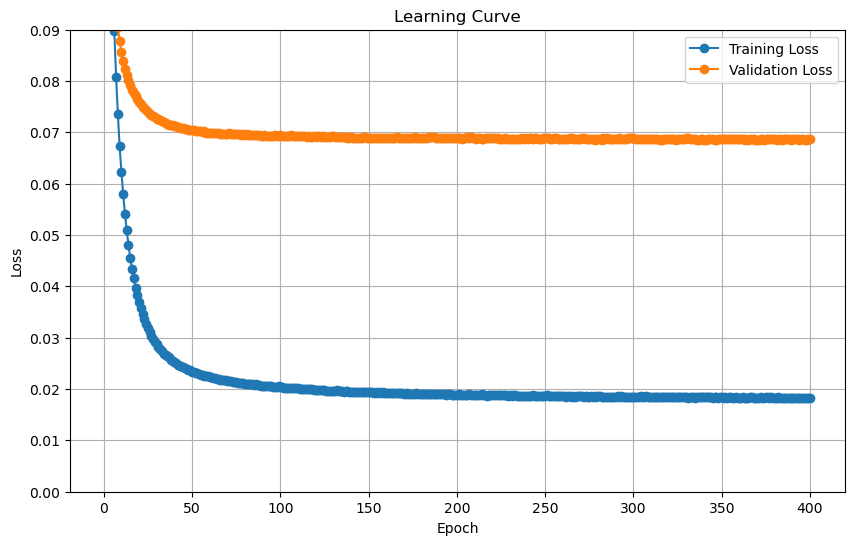

In [ ]:

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Define a two-layer feedforward neural network class with optional dropout
class TwoLayerFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5, use_dropout=True):
        super(TwoLayerFNN, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_prob)
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set hyperparameters for training
use_dropout = True
droupout_prob = 0.3
layer_name = "layer3"  
pca = True
l2 = True
weight_decay = 5e-4
lr = 5e-5
lr = 0.00005
hidden_dim = 1024
num_epochs = 400 

print(f"Using PCA: {pca}, Layer: {layer_name}, Dropout: {use_dropout}, Dropout Rate: {droupout_prob}, L2: {l2} - {weight_decay} Learning Rate: {lr}, Hidden Dim: {hidden_dim}, Epochs: {num_epochs}")

# Load PCA-transformed data for training and validation, or raw activations if PCA is not used
X_train = pca_activations_train[layer_name] if pca else activations_dct_train[layer_name]  
X_val   = pca_activations_val[layer_name] if pca else activations_dct_val[layer_name]
Y_train = spikes_train
Y_val   = spikes_val

# Set input and output dimensions based on training data
input_dim = X_train.shape[1]
output_dim = spikes_train.shape[1]


model = TwoLayerFNN(input_dim, hidden_dim, output_dim, dropout_prob=droupout_prob, use_dropout=use_dropout).to(device)


# Convert the training and validation data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)  

# Create PyTorch datasets and data loaders for training and validation
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = nn.MSELoss()

if l2 :
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay= weight_decay)
else :
    optimizer = optim.Adam(model.parameters(), lr=lr)



train_loss = []
val_loss = []

# Training loop for specified number of epochs
for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, targets)  
        loss.backward()         
        optimizer.step()        
        
        running_train_loss += loss.item()
    average_train_loss = running_train_loss / len(train_loader)
    train_loss.append(average_train_loss) 

    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
    
    average_val_loss = running_val_loss / len(val_loader)
    val_loss.append(average_val_loss) 
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")
# Plot the learning curves for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.09)
plt.show()



model evaluation:

In [16]:
model.eval()  
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_predictions.append(outputs.cpu())
        all_targets.append(targets.cpu())

Y_pred = torch.cat(all_predictions, dim=0).numpy()
Y_val = torch.cat(all_targets, dim=0).numpy()

ev = summarize(explained_variance_score(Y_val, Y_pred, multioutput='raw_values'))
r  = summarize(compute_pearson_per_neuron(Y_val, Y_pred))
print(f"Explained Variance: {ev}")
print(f"Pearson Correlation: {r}")

save_path = "best_model_weights.pth"
torch.save(model.state_dict(), save_path)

Explained Variance: {'P25': 0.351575568318367, 'median': 0.4657519, 'P75': 0.5548744201660156}
Pearson Correlation: {'P25': 0.5941202193498611, 'median': 0.6880427, 'P75': 0.7504414916038513}
